### **Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import Libraries**

In [ ]:
import json
import math
import os

from keras import layers
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Add, MaxPooling2D, Conv2D, Flatten, BatchNormalization

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import gc
import itertools
from tqdm import tqdm
from PIL import Image
from functools import partial
from collections import Counter

%matplotlib inline

### **Load Data**

In [ ]:
# Transfer 'jpg' images to an array IMG

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)           
            img = cv2.resize(img, (RESIZE, RESIZE))           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:11<00:00, 33.18it/s]


### **Data Preprocessing**

In [ ]:
# Print label names
label =  {0:"benign", 1:"malignant"}
for i in label.keys() :
    print(i, label[i])

0 benign
1 malignant


In [ ]:
# Breast Cancer: Malignant vs. Benign

# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size = 0.2, 
    random_state = 11
)

### **Visualization of Data**

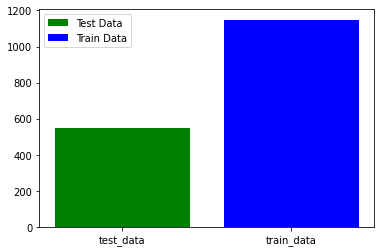

In [ ]:
# Test & Train data

fig, axis = plt.subplots()
axis.bar("test_data", 547, color='g', label='Test Data')
axis.bar("train_data", 1148 , color='b', label='Train Data')
legend = axis.legend()

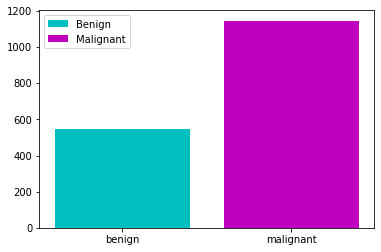

In [ ]:
# Benign & Malignant Data

fig, axis = plt.subplots()
axis.bar("benign", 547, color='c', label='Benign')
axis.bar("malignant", 1146 , color='m', label='Malignant')
legend = axis.legend()

In [ ]:
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range =2,  
        rotation_range = 90,
        horizontal_flip = True,  
        vertical_flip = True, 
    )

### **Display the Images**

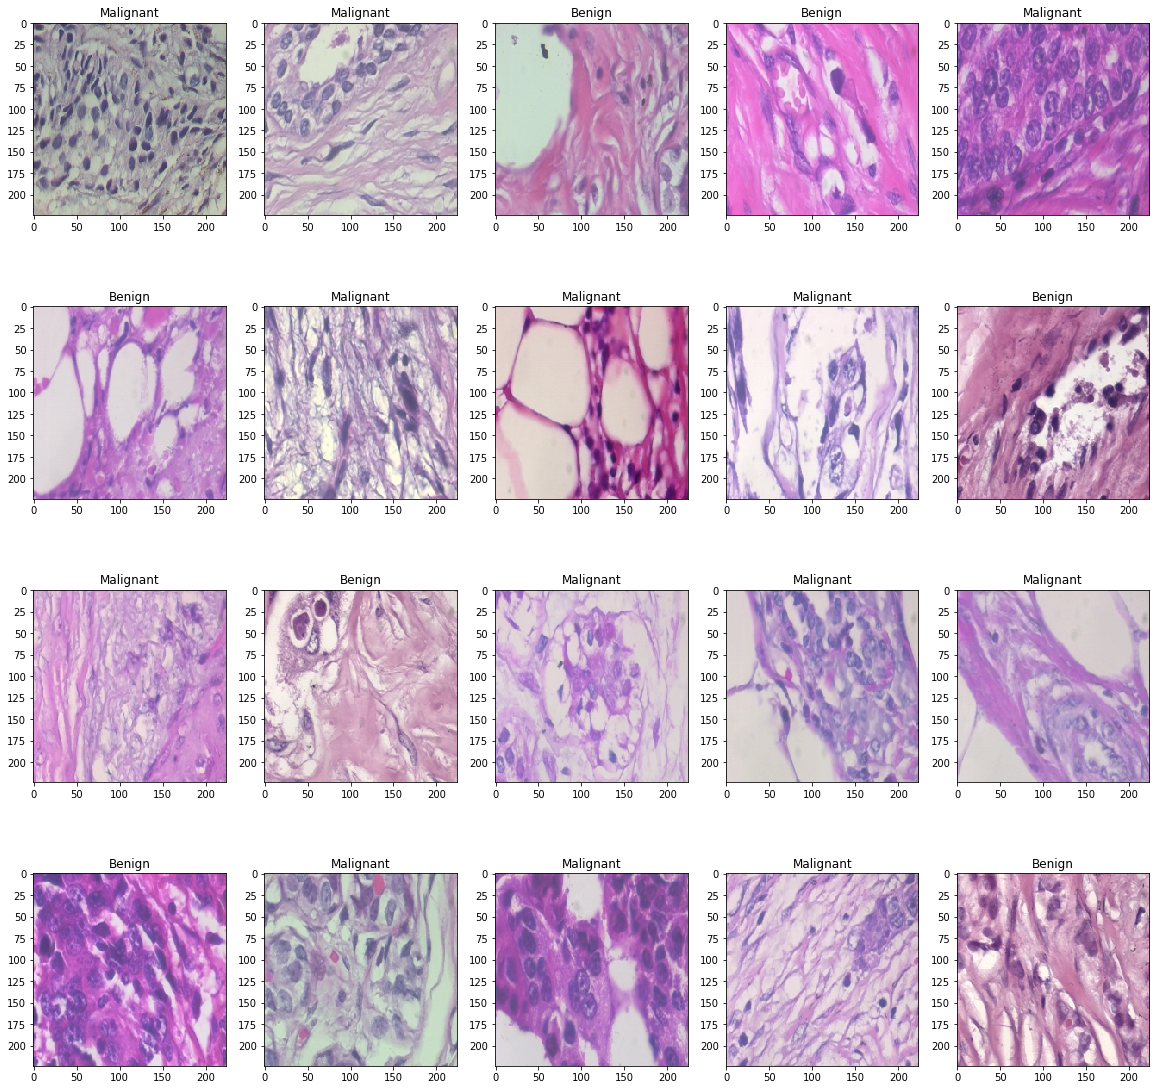

In [ ]:
w = 80
h = 50
fig = plt.figure(figsize = (20, 20))
columns = 5
rows = 4

for i in range(1, columns*rows+1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

### **Build CNN Model**

In [ ]:
def build_model(backbone, lr = 1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(lr=lr),
        metrics = ['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

#DenseNet-201 is a convolutional neural network that is 201 layers deep.
resnet = DenseNet201(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

### **Train the Model**

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size = BATCH_SIZE),
    steps_per_epoch = x_train.shape[0] / BATCH_SIZE,
    epochs = 10,
    validation_data = (x_val, y_val),
    callbacks = [early_stop]
)

Epoch 1/10
57/57 [==============================] - 997s 17s/step - loss: 0.7662 - accuracy: 0.5840 - val_loss: 0.6647 - val_accuracy: 0.6320
Epoch 2/10
57/57 [==============================] - 973s 17s/step - loss: 0.6152 - accuracy: 0.7281 - val_loss: 0.6652 - val_accuracy: 0.6320
Epoch 3/10
57/57 [==============================] - 982s 17s/step - loss: 0.5589 - accuracy: 0.7725 - val_loss: 0.6194 - val_accuracy: 0.6494
Epoch 4/10
57/57 [==============================] - 977s 17s/step - loss: 0.5098 - accuracy: 0.8332 - val_loss: 0.3328 - val_accuracy: 0.8701
Epoch 5/10
57/57 [==============================] - 970s 17s/step - loss: 0.4685 - accuracy: 0.8342 - val_loss: 0.3039 - val_accuracy: 0.9048
Epoch 6/10
57/57 [==============================] - 982s 17s/step - loss: 0.4681 - accuracy: 0.8310 - val_loss: 0.2516 - val_accuracy: 0.9091
Epoch 7/10
57/57 [==============================] - 981s 17s/step - loss: 0.4471 - accuracy: 0.8429 - val_loss: 0.3567 - val_accuracy: 0.8571
Epoch 

In [ ]:
# Evaluate model

model.evaluate(x_val, y_val)

8/8 [==============================] - 42s 5s/step - loss: 0.2863 - accuracy: 0.9437


[0.2862679958343506, 0.9437229633331299]

### **Prediction**

In [ ]:
Y_pred = model.predict(X_test)
#Y_pred = np.argmax(Y_pred,axis=1)
Y_val_pred = model.predict(x_val)
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis = 1))

0.9437229437229437

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [17:48<00:00, 106.89s/it]


### **Test the Model**

[0]
benign


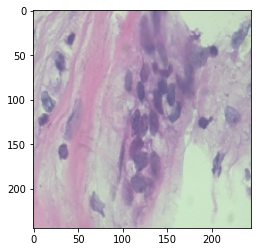

In [ ]:
# Model Test 1
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-004.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


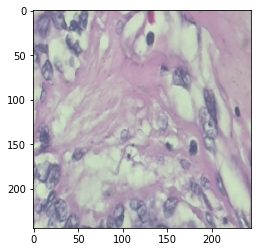

In [ ]:
# Model Test 2
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/benign/SOB_B_F-14-21998EF-400-011.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


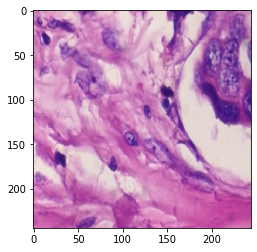

In [ ]:
# Model Test 3
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/test/malignant/SOB_M_DC-14-12312-400-026.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


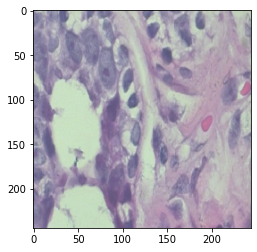

In [ ]:
# Model Test 4
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-008.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


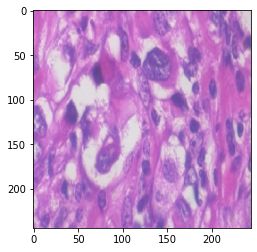

In [ ]:
# Model Test 5
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-4372-400-001.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


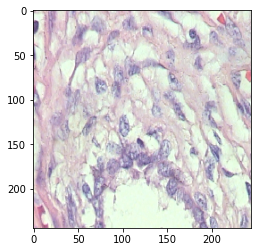

In [ ]:
# Model Test 6
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/benign/SOB_B_F-14-23222AB-400-018.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


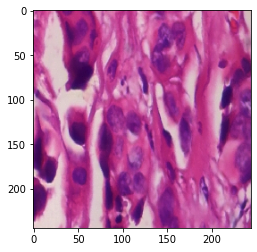

In [ ]:
# Model Test 7
img_ = image.load_img("/content/drive/MyDrive/BreaKHis 400X/train/malignant/SOB_M_DC-14-9461-400-022.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

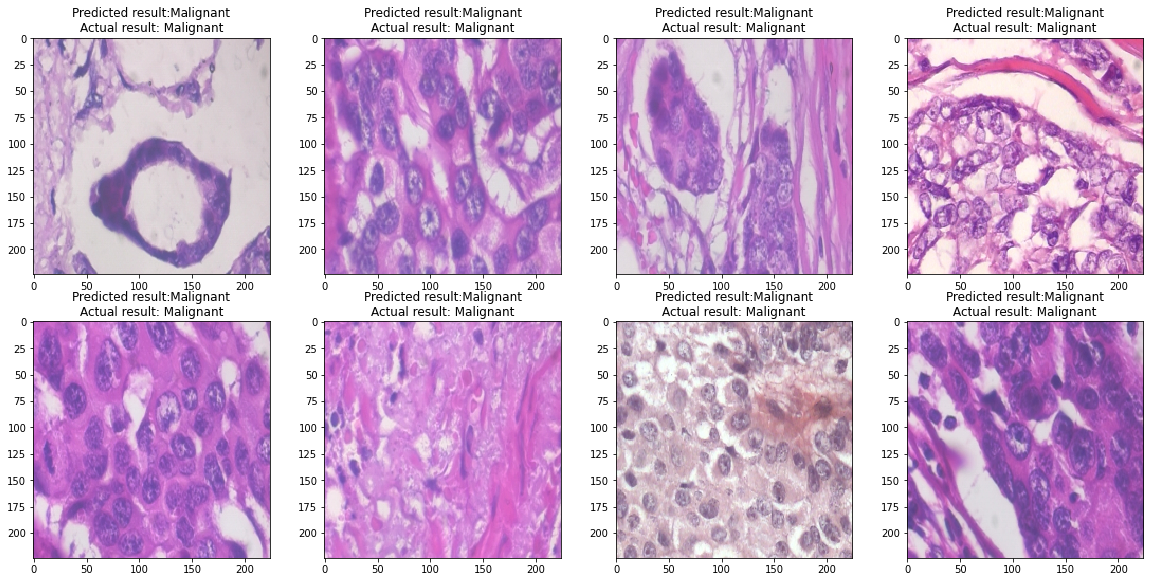

In [ ]:
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class) == 8):
        break

i = 0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class) == 8):
        break

#Display first 8 images of malignant
w = 80
h = 50
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 4

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

### **Plot the Values**

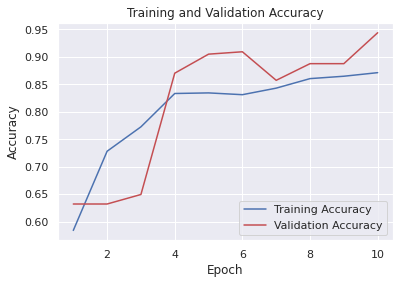

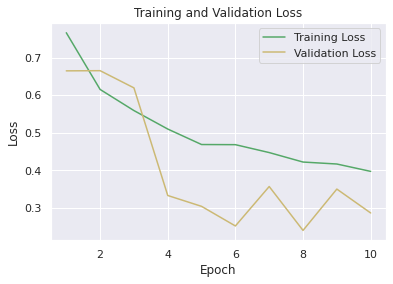

In [ ]:
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Accuracy plot
plt.plot(epochs, accuracy, color = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, color = 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
 
# Loss plot
plt.figure()
plt.plot(epochs, loss, color = 'g', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'y', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### **Confusion Matrix**

Confusion matrix, without normalization
[[150  26]
 [ 29 340]]


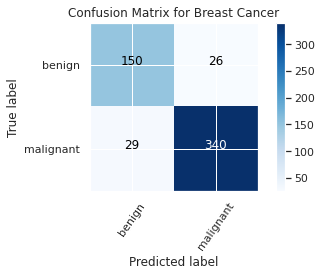

In [ ]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title = 'Confusion Matrix for Breast Cancer')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       176
           1       0.89      0.92      0.90       369

    accuracy                           0.87       545
   macro avg       0.85      0.84      0.85       545
weighted avg       0.87      0.87      0.87       545

